# problem statement

Forecast CocaCola prices data set. Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.

In [12]:
# Import basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

In [4]:
# Import data

rawData = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
print('\n \033[7m CocaCola Sales Data - Quarterly \033[0m')
rawData.head()


  CocaCola Sales Data - Quarterly 


,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [37]:
print('\n \033[7m Technical information of the data \033[0m ')
print(rawData.info())
print('\n \033[7m Basic Statistics of the data \033[0m ')
rawData.describe().T


  Technical information of the data  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes
None

  Basic Statistics of the data  


,count,mean,std,min,25%,50%,75%,max
Sales,42.0,2994.353308,977.930896,1547.818996,2159.714247,2782.376999,3609.25,5253.0


# Data Visualization

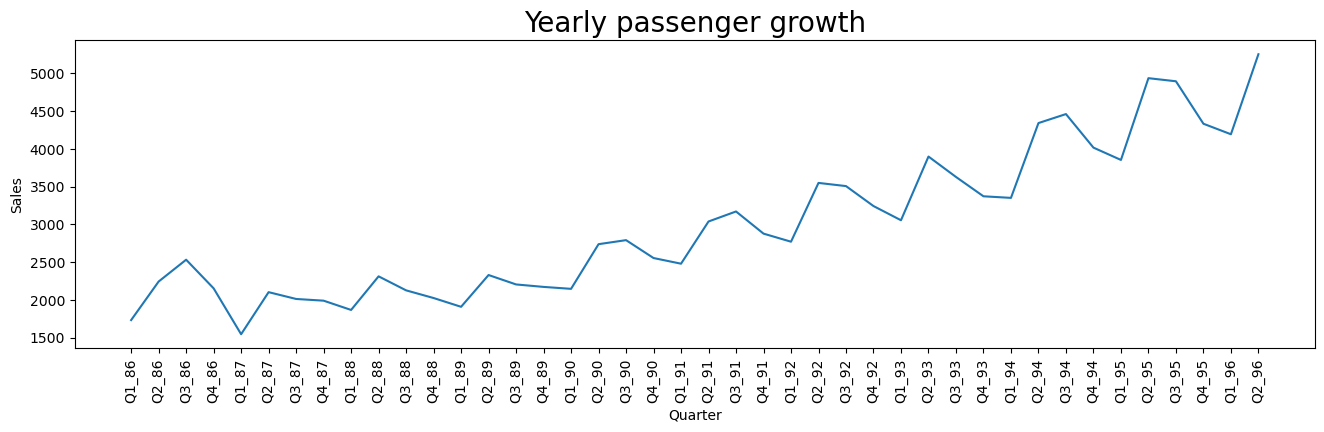

In [8]:
# simple line plot 

plt.figure(figsize=(16,4))
sns.lineplot(x = rawData.Quarter, y=rawData.Sales)
plt.xticks(rotation=90)
plt.title('Yearly passenger growth', fontsize = 20)
plt.show()

**The data shows that there is a trend along with additive seasonality.**

Text(0.5, 1.0, 'lagplot')

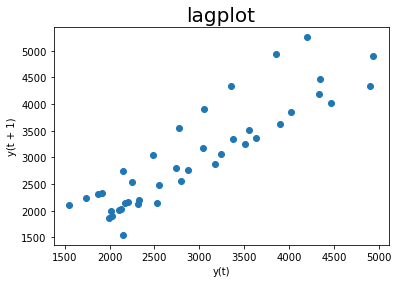

In [16]:
# lag Plot for t and t+1

pd.plotting.lag_plot(rawData.Sales)
plt.title('lagplot', fontsize = 20)
plt.show()

The Lagplot shows, not so strong but a definite positive correlation 

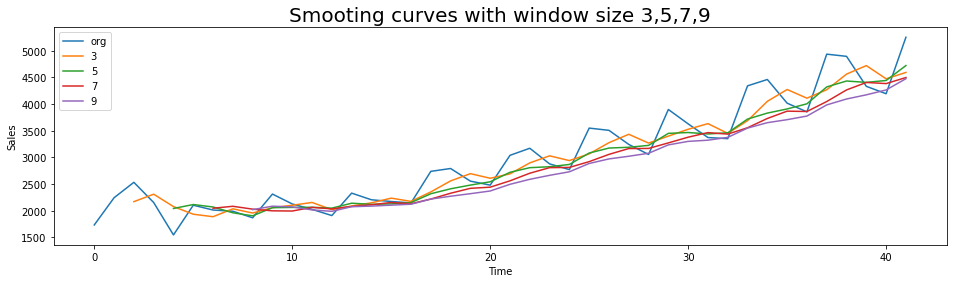

In [18]:
# line plot to check Smoothing using rolling mean technique - Moving Average

plt.figure(figsize=(16,4))
rawData.Sales.plot(label="org")
for i in range(3,10,2):
    rawData.Sales.rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')
plt.title('Smooting curves with window size 3,5,7,9', fontsize = 20)
plt.xlabel('Time'),plt.ylabel('Sales')
plt.show()

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsa_plots


  Decomposition plot - Showing Trend, Seasonality and Residuals  



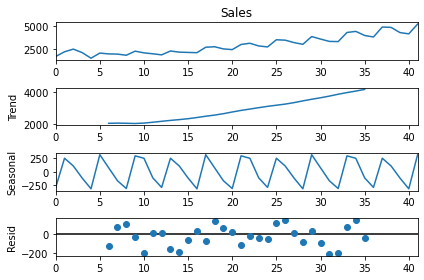

In [31]:
# Decomposition plot to understand the level, trend and sesonality in the time series.

print('\n \033[7m Decomposition plot - Showing Trend, Seasonality and Residuals \033[0m \n')
decompose_ts_add = seasonal_decompose(rawData.Sales,period=12)
decompose_ts_add.plot()
plt.show()

*We can clearly see that there is additive seasonality with linear trend in the data.*


  Autocorrelation and Partial Autocorrelation pltos  



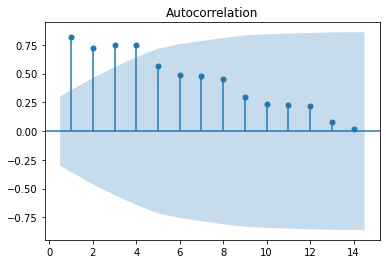

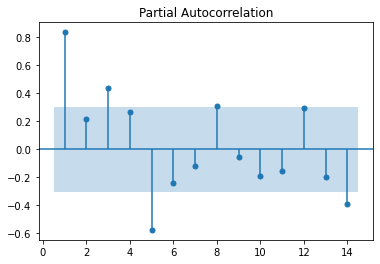

In [46]:
# ACF and PACF Plots for 24 lags

print('\n \033[7m Autocorrelation and Partial Autocorrelation pltos \033[0m \n')
tsa_plots.plot_acf(rawData.Sales,lags=14,zero=False)
tsa_plots.plot_pacf(rawData.Sales,lags=14,zero=False)
plt.show()

*Auto-correlation factor plot shows T-4 lags have a strong correlation. where as Partial Auto-correlation factor plot show lag T-1 has the greatest influence on the prediction of T. So, we shall use t-1 as our chosen lag for building the models.* 

# Data Preparation 

## Creating Dummy Variables

In [52]:
# Making a copy of raw data for data manupulation
data = rawData.copy(deep=True)
print('\n \033[7m Copy of Quarterly Sales Data \033[0m ')
data.head()


  Copy of Quarterly Sales Data  


,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [53]:
# Creating time variable in no of months

def heading(title):
    print(f'\n \033[7m {title} \033[0m ')

heading('Adding range of Time variable starting from 1')
data['t'] = range(1,len(data)+1)
data.head()


  Adding range of Time variable starting from 1  


,Quarter,Sales,t
0,Q1_86,1734.827000,1
1,Q2_86,2244.960999,2
2,Q3_86,2533.804993,3
3,Q4_86,2154.962997,4
4,Q1_87,1547.818996,5


In [54]:
# Creating dummy variable Log to check the exponential relationship
heading('Adding Dummy variable for log values of sales')
data['log'] = np.log(data.Sales)
data.head()


  Adding Dummy variable for log values of sales  


,Quarter,Sales,t,log
0,Q1_86,1734.827000,1,7.458663
1,Q2_86,2244.960999,2,7.716443
2,Q3_86,2533.804993,3,7.837477
3,Q4_86,2154.962997,4,7.675529
4,Q1_87,1547.818996,5,7.344602


In [17]:
# Extracting month and year features in datafrme

data['month'] = pd.to_datetime(data.index).strftime('%b')
data['year'] = data.index.year
data

,Passengers,t,sqRoot,log,month,year
Month,,,,,,
1995-01-01,112,1,10.583005,4.718499,Jan,1995
1995-02-01,118,2,10.862780,4.770685,Feb,1995
1995-03-01,132,3,11.489125,4.882802,Mar,1995
1995-04-01,129,4,11.357817,4.859812,Apr,1995
1995-05-01,121,5,11.000000,4.795791,May,1995
...,...,...,...,...,...,...
2002-08-01,405,92,20.124612,6.003887,Aug,2002
2002-09-01,355,93,18.841444,5.872118,Sep,2002
2002-10-01,306,94,17.492856,5.723585,Oct,2002


In [18]:
# creating a dummy variable t-Sq (square of t) to check the exponential relationship

data['t-Sq'] = np.square(data.t)
data

,Passengers,t,sqRoot,log,month,year,t-Sq
Month,,,,,,,
1995-01-01,112,1,10.583005,4.718499,Jan,1995,1
1995-02-01,118,2,10.862780,4.770685,Feb,1995,4
1995-03-01,132,3,11.489125,4.882802,Mar,1995,9
1995-04-01,129,4,11.357817,4.859812,Apr,1995,16
1995-05-01,121,5,11.000000,4.795791,May,1995,25
...,...,...,...,...,...,...,...
2002-08-01,405,92,20.124612,6.003887,Aug,2002,8464
2002-09-01,355,93,18.841444,5.872118,Sep,2002,8649
2002-10-01,306,94,17.492856,5.723585,Oct,2002,8836


In [19]:
#creating dummy variables for months, using get_dummies(), for checking the seasonality

data = pd.get_dummies(data,prefix='',prefix_sep='')
data

,Passengers,t,sqRoot,log,year,t-Sq,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Month,,,,,,,,,,,,,,,,,,
1995-01-01,112,1,10.583005,4.718499,1995,1,0,0,0,0,1,0,0,0,0,0,0,0
1995-02-01,118,2,10.862780,4.770685,1995,4,0,0,0,1,0,0,0,0,0,0,0,0
1995-03-01,132,3,11.489125,4.882802,1995,9,0,0,0,0,0,0,0,1,0,0,0,0
1995-04-01,129,4,11.357817,4.859812,1995,16,1,0,0,0,0,0,0,0,0,0,0,0
1995-05-01,121,5,11.000000,4.795791,1995,25,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-08-01,405,92,20.124612,6.003887,2002,8464,0,1,0,0,0,0,0,0,0,0,0,0
2002-09-01,355,93,18.841444,5.872118,2002,8649,0,0,0,0,0,0,0,0,0,0,0,1
2002-10-01,306,94,17.492856,5.723585,2002,8836,0,0,0,0,0,0,0,0,0,0,1,0


In [20]:
# reinserting the month column as get_dummies removed the same in the previous step

data.insert(loc = 4, column='month', value = pd.to_datetime(data.index).strftime('%b'))
data

,Passengers,t,sqRoot,log,month,year,t-Sq,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Month,,,,,,,,,,,,,,,,,,,
1995-01-01,112,1,10.583005,4.718499,Jan,1995,1,0,0,0,0,1,0,0,0,0,0,0,0
1995-02-01,118,2,10.862780,4.770685,Feb,1995,4,0,0,0,1,0,0,0,0,0,0,0,0
1995-03-01,132,3,11.489125,4.882802,Mar,1995,9,0,0,0,0,0,0,0,1,0,0,0,0
1995-04-01,129,4,11.357817,4.859812,Apr,1995,16,1,0,0,0,0,0,0,0,0,0,0,0
1995-05-01,121,5,11.000000,4.795791,May,1995,25,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-08-01,405,92,20.124612,6.003887,Aug,2002,8464,0,1,0,0,0,0,0,0,0,0,0,0
2002-09-01,355,93,18.841444,5.872118,Sep,2002,8649,0,0,0,0,0,0,0,0,0,0,0,1
2002-10-01,306,94,17.492856,5.723585,Oct,2002,8836,0,0,0,0,0,0,0,0,0,0,1,0


## Visualizing the Data with Dummy Variables

<AxesSubplot:xlabel='month', ylabel='year'>

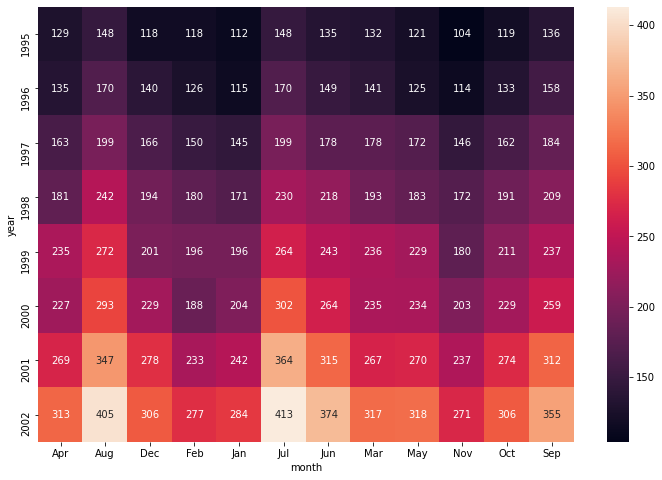

In [21]:
# Heat map to check the monthly and yearly relationship pattern. It is not intutive though

plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=data, values="Passengers", index="year", 
                                 columns="month", aggfunc="mean", fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

<AxesSubplot:xlabel='year', ylabel='Passengers'>

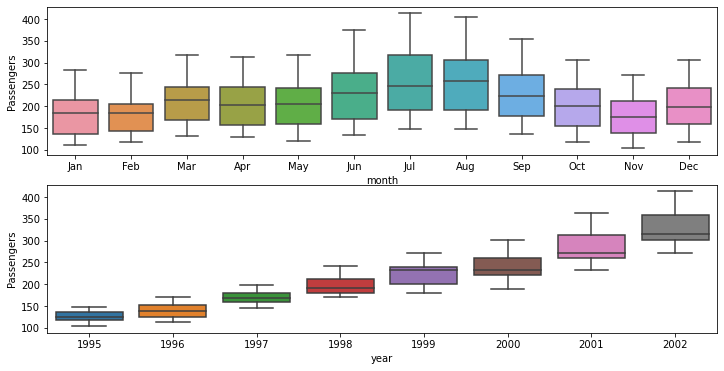

In [22]:
# Boxplot for every year and month - ORIGINAL DATA

plt.figure(figsize=(12,6))
plt.subplot(211)
sns.boxplot(x="month",y="Passengers",data=data)
plt.subplot(212)
sns.boxplot(x="year",y="Passengers",data=data)


**months of June July and August have highest passenger count for all years put together.**

<AxesSubplot:xlabel='year', ylabel='sqRoot'>

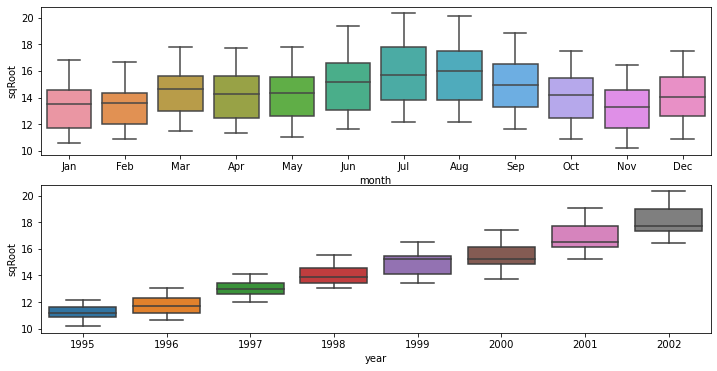

In [23]:
# Boxplot for every year and month - Dummy variable `sqRoot of Passengers`

plt.figure(figsize=(12,6))
plt.subplot(211)
sns.boxplot(x="month",y="sqRoot",data=data)
plt.subplot(212)
sns.boxplot(x="year",y="sqRoot",data=data)


<AxesSubplot:xlabel='year', ylabel='log'>

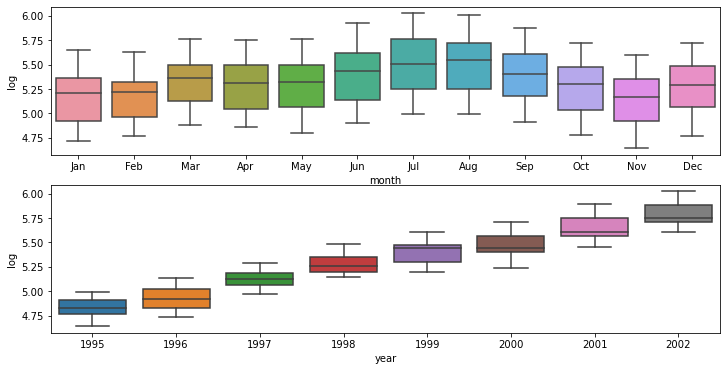

In [24]:
# Boxplot for every year and month - using Dummy variable log of passengers

plt.figure(figsize=(12,6))
plt.subplot(211)
sns.boxplot(x="month",y="log",data=data)
plt.subplot(212)
sns.boxplot(x="year",y="log",data=data)


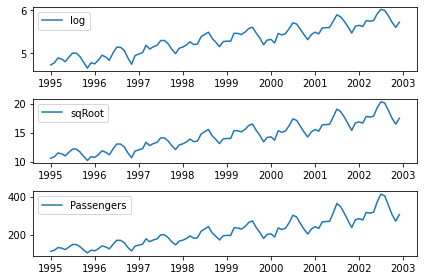

In [25]:
# line plot comparing all the variables - original and dummy

plt.subplot(311)
plt.plot(data.log, label = 'log')
plt.legend(loc='best')
plt.subplot(312)
plt.plot(data.sqRoot, label = 'sqRoot')
plt.legend(loc='best')
plt.subplot(313)
plt.plot(data.Passengers, label = 'Passengers')
plt.legend(loc='best')
plt.tight_layout()

**Log transformation works best to make seasonal component equal across the time series.**

## Splitting the data into Train and Test for `Model Training`

In [26]:
# Splitting the data

Train = data.head(84)
Test = data.tail(12)

# Model Building
======================

**Evaluation Metric MAPE**

In [27]:
# Function for MAPE calculation

def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

## Model based approach

    Model based approach assumes that future depends on past till eternity. This may be true or this may not be true. one simple fact is that the immediate past has bigger influence on the future than the long past data.

### Linear model

Linear model is the simplest mode of all the models under model based approach. it assumes linear relationship between t and y.

    * It works well when there is no seasonal component in the Time series
    * It works well if there is a constant trend in the Time series, i.e. linear trend.

This is not suitable for our AirPassenger time series as there is a strong component of seasonality. However, we will try this model the compare with other models in model based approach.

In [28]:
# Linear Model

import statsmodels.formula.api as smf 

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
MAPE_linear = MAPE(pred_linear,Test['Passengers'])
rmse_linear,MAPE_linear

(53.199236534802715, 10.787458780263671)

### Exponential model

Transformations are applied on the y values to make them normally distributed. In this case we are working with log transformation as this works better on the data than the square root transformation.

    * This works well when the trend is non linear or exponential in nature. It fails to capture cyclical trends in the Time series.
    * This model still fails to capture seasonal component like the linear model. 
    
This is also not suitable for our AirPassenger time series as there is a strong component of seasonality. However, we will try this model the compare with other models in model based approach.

In [29]:
# Exponential model

Exp = smf.ols('log~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
MAPE_Exp = MAPE(np.exp(pred_Exp),Test['Passengers'])
rmse_Exp,MAPE_Exp


(46.0573611031562, 10.66573871088376)

### Quadratic model

Quadratic model try to capture the bi-directional trends. i.e. raising and falling trends, such as business cycles which occur every few years. 

    * This model will try to capture cyclical trends over the years but they fail to absorb the seasonal component mostly.
    
This is also not suitable for our AirPassenger time series as there is no presence of cyclical trend but a strong component of seasonality is present. However, we will try this model the compare with other models in model based approach.

In [30]:
# Quadratic model

Quad = smf.ols('Passengers~t+t-Sq',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t-Sq"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
MAPE_Quad = MAPE(pred_Quad,Test['Passengers'])
rmse_Quad,MAPE_Quad

(53.199236534802715, 10.787458780263671)

### Base model with Additive seasonality

This model tries to capture the seasonality alone considering the constant level in the data. This is also not suitable for our data as we have a component of trend and seasonality. But this will help us check the nature of seasonality, i.e. whether seasonality is additive or multiplicative.

*`Seasonality is the variation in the time series within a year.`*

    * Additive Seasonality describes that the variation in the seasonality is constant over the years.
    * Multiplicative Seasonality describes the growing seasonal variation over the years.


In [31]:
#Additive seasonality 

add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun',
                                               'Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
MAPE_add_sea = MAPE(pred_add_sea,Test['Passengers'])
rmse_add_sea,MAPE_add_sea

(132.81978481421817, 39.728616686874396)

### Base model with constant trend and Multiplicative Seasonality

As discussed above multiplicative seasonality shows an increasing variation with respect to years.

We will try to check the type of seasonality using this model.

`Clearly we can see that additive seasonality gives less error then multiplicative seasonality. however we can not discard any one of them as the difference is not that high.`

In [32]:
##Multiplicative Seasonality

Mult_sea = smf.ols('log~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mult_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
MAPE_Mult_sea = MAPE(np.exp(pred_Mult_sea),Test['Passengers'])
rmse_Mult_sea,MAPE_Mult_sea

(140.06320204708615, 41.875240929185175)

### Additive seasonality with additive/constant trend

This will try to capture the non linear trend along with the additive seasonality in the time series. This is also not suitable as the trend is not quadratic in nature. 

In [33]:
#Additive trend with additive Seasonality 

add_sea_add_tr = smf.ols('Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_add_tr = pd.Series(add_sea_add_tr.predict(Test[['Jan','Feb','Mar','Apr','May','Jun',
                                                         'Jul','Aug','Sep','Oct','Nov','t']]))
rmse_add_sea_add_tr = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_add_tr))**2))
MAPE_add_sea_add_tr = MAPE(pred_add_sea_add_tr,Test['Passengers'])
rmse_add_sea_add_tr,MAPE_add_sea_add_tr

(35.34895688467283, 7.578667788535856)

### Multiplicative trend with Multiplicative Seasonality

This is the combination of multiplicative trend and multiplicative seasonality. This is a good combination for our time series as there is exponential trend and multiplicative seasonality.

In [34]:
#Multiplicative Seasonality with multiplicative trend 

Mult_tr_Mul_sea = smf.ols('log~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_tr_Mul_sea = pd.Series(Mult_tr_Mul_sea.predict(Test))
rmse_Mult_tr_Mul_sea = np.sqrt(np.mean((np.array(Test['Passengers'])
                                        -np.array(np.exp(pred_Mult_tr_Mul_sea)))**2))
MAPE_Mult_tr_Mul_sea = MAPE(np.exp(pred_Mult_tr_Mul_sea),Test['Passengers'])
rmse_Mult_tr_Mul_sea,MAPE_Mult_tr_Mul_sea

(10.519172544323922, 2.3752408474928695)

# Data Driven Models
    
    Data driven models assume that future may or may not completely depend on the past. They rely more on the immediate past to predict the future. 

In [35]:
# Import libraries for datadriven models

from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

### Simple Exponential Method

In [36]:
ses_model = SimpleExpSmoothing(Train["Passengers"]).fit(smoothing_level=0.23)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE_ses = MAPE(pred_ses,Test.Passengers) 
rmse_ses = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_ses))**2))
print(rmse_ses, MAPE_ses)

64.61182394552621 13.349070149128151


C:\Users\MMM-SM\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


### Holt Method

In [37]:
# Holt method 
hw_model = Holt(Train["Passengers"]).fit(smoothing_level=0.23, smoothing_trend=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE_hw = MAPE(pred_hw,Test.Passengers) 
rmse_hw = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_hw))**2))
print(rmse_hw, MAPE_hw)

47.963138144652405 10.431245070348746


### Holt Winter Additive Method

In [38]:
hwe_model_add_add = ExponentialSmoothing(Train["Passengers"],seasonal="add",
                                         trend="add",seasonal_periods=12).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE_hwe = MAPE(pred_hwe_add_add,Test.Passengers)
rmse_hwe = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_hwe_add_add))**2))
print(rmse_hwe, MAPE_hwe)

28.79391476828249 5.495938663841666


### Holt Winter Exponential Method

In [39]:
hwe_model_mul_add = ExponentialSmoothing(Train["Passengers"],seasonal="mul",trend="add",
                                         seasonal_periods=12).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE_hwe_mul = MAPE(pred_hwe_mul_add,Test.Passengers)
rmse_hwe_mul = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_hwe_mul_add))**2))
print(rmse_hwe_mul, MAPE_hwe_mul)

12.921284284293778 2.821237608921072


# ARIMA models 

ARIMA models assume stationary time series i.e. no trend and no seasonality. Hence it may not be suitable for the time series under consideration. still we will try and build a model with hyper parameter tuning to see how it performs. I have no expectations. 

In [40]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [41]:
# grid search ARIMA parameters for a time series

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, Y, arima_order):
# prepare training dataset
    train = X.astype('float64')
    test = Y.astype('float64')
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order )
# model_fit = model.fit(disp=0)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
#     mape = MAPE(predictions,test)
    return rmse

In [42]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA--%s RMSE--=%.3f' % (best_cfg, best_score))

In [43]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(Train.Passengers, Test.Passengers, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=131.471
ARIMA(0, 0, 1) RMSE=69.553
ARIMA(0, 1, 0) RMSE=34.018
ARIMA(0, 1, 1) RMSE=30.908
ARIMA(0, 1, 2) RMSE=35.310
ARIMA(0, 1, 3) RMSE=30.011
ARIMA(0, 1, 4) RMSE=26.950
ARIMA(0, 2, 0) RMSE=38.498
ARIMA(0, 2, 1) RMSE=34.722
ARIMA(0, 2, 2) RMSE=31.370
ARIMA(0, 2, 3) RMSE=31.490
ARIMA(0, 2, 4) RMSE=29.486
ARIMA(1, 0, 0) RMSE=34.552
ARIMA(1, 0, 1) RMSE=31.134
ARIMA(1, 0, 2) RMSE=31.014
ARIMA(1, 1, 0) RMSE=32.273
ARIMA(1, 1, 1) RMSE=34.571
ARIMA(1, 1, 2) RMSE=28.493
ARIMA(1, 2, 0) RMSE=38.802
ARIMA(2, 0, 0) RMSE=32.548
ARIMA(2, 0, 1) RMSE=30.740
ARIMA(2, 1, 0) RMSE=31.118
ARIMA(2, 1, 1) RMSE=28.442
ARIMA(2, 1, 2) RMSE=28.450
ARIMA(2, 1, 3) RMSE=28.147
ARIMA(2, 2, 0) RMSE=36.564
ARIMA(3, 0, 0) RMSE=31.530
ARIMA(3, 0, 1) RMSE=28.066
ARIMA(3, 1, 0) RMSE=31.673
ARIMA(3, 1, 1) RMSE=28.831
ARIMA(3, 1, 2) RMSE=27.665
ARIMA(3, 2, 0) RMSE=37.261
ARIMA(4, 0, 0) RMSE=32.059
ARIMA(4, 1, 0) RMSE=29.335
ARIMA(4, 1, 1) RMSE=28.986
ARIMA(4, 1, 2) RMSE=34.050
ARIMA(4, 1, 4) RMSE=28.346


***Consistently the ARIMA models show high RMSE hence not suitable and not considered/selected as a model.***

# Model Selection

    As it can be seen that the model based approach gives us better result. we shall choose to build a model using multiplicative trend and multiplicative seasonality, as it gives the lowest RMSE and MAPE values. MAPE is around 2% which is acceptable in my opinion. 

### Compare results using RMSE and MAPE Values

In [44]:
#Compare the results 

rmse_dict = {"MODEL":pd.Series(["linear","Exp","Quad","add_sea","Mult_sea","add_sea_add_tr",
                                "Mult_tr_Mul_sea","ses_model", "hw_model", "hwe_model_add_add",
                                "hwe_model_mul_add" ]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_Mult_sea,
                                 rmse_add_sea_add_tr,rmse_Mult_tr_Mul_sea,rmse_ses,rmse_hw,
                                      rmse_hwe,rmse_hwe_mul]),
            "MAPE_Values" : pd.Series([MAPE_linear,MAPE_Exp,MAPE_Quad,MAPE_add_sea,MAPE_Mult_sea,
                                 MAPE_add_sea_add_tr,MAPE_Mult_tr_Mul_sea,MAPE_ses,MAPE_hw,
                                      MAPE_hwe,MAPE_hwe_mul])}
table_rmse=pd.DataFrame(rmse_dict)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values,MAPE_Values
6,Mult_tr_Mul_sea,10.519173,2.375241
10,hwe_model_mul_add,12.921284,2.821238
9,hwe_model_add_add,28.793915,5.495939
5,add_sea_add_tr,35.348957,7.578668
1,Exp,46.057361,10.665739
8,hw_model,47.963138,10.431245
0,linear,53.199237,10.787459
2,Quad,53.199237,10.787459
7,ses_model,64.611824,13.349070
3,add_sea,132.819785,39.728617


### Model Evaluation - Plotting predictions of three top models

In [45]:
Fdata = pd.Series(Test.Passengers.copy(deep=True))
Fdata = pd.concat([Fdata,pd.Series(pred_hwe_add_add),pd.Series(pred_hwe_mul_add),
           pd.Series(np.exp(pred_Mult_tr_Mul_sea))], 
          axis=1 )
Fdata.columns =['Passengers','HWE_add','HWE_Mult','Mul_Mul_sea']
Fdata

,Passengers,HWE_add,HWE_Mult,Mul_Mul_sea
Month,,,,
2002-01-01,284,282.172066,281.191640,279.259237
2002-02-01,277,283.033368,278.383564,283.647937
2002-03-01,317,310.315570,322.559341,327.699745
2002-04-01,313,304.171274,312.455696,316.197279
2002-05-01,318,303.456204,311.023434,313.139118
2002-06-01,374,327.462721,348.874252,352.485470
2002-07-01,413,352.474510,389.545710,392.396393
2002-08-01,405,351.627848,384.750512,392.543731
2002-09-01,355,326.491806,341.857629,352.653113


<AxesSubplot:xlabel='Month'>

<Figure size 1080x216 with 0 Axes>

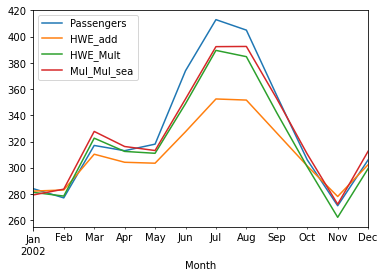

In [46]:
plt.figure(figsize=(15,3))
Fdata.plot()

**We can see that the Green and red lines are closely following the Blue Line. Let us build the final model with Mul_tr_mul_sea.**

# Final Model

    As noted from above we will take a model based approach to build our final model. we shall use multiplicative trend and multiplicative seasonality.

In [47]:
#Multiplicative Seasonality with multiplicative trend 

F_Mult_tr_Mul_sea = smf.ols('log~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = data).fit()
F_pred_Mult_tr_Mul_sea = pd.Series(F_Mult_tr_Mul_sea.predict(data))
F_rmse_Mult_tr_Mul_sea = np.sqrt(np.mean((np.array(data['Passengers'])
                                        -np.array(np.exp(F_pred_Mult_tr_Mul_sea)))**2))
F_MAPE_Mult_tr_Mul_sea = MAPE(np.exp(F_pred_Mult_tr_Mul_sea),data['Passengers'])
F_rmse_Mult_tr_Mul_sea,F_MAPE_Mult_tr_Mul_sea

(8.93354846771259, 3.4448962270251116)

In [48]:
# Verifying the final model with predictions

FFdata = pd.Series(data.Passengers.copy(deep=True))
FFdata = pd.concat([FFdata,pd.Series(np.exp(pred_Mult_tr_Mul_sea),name='Pred_passengers')],axis=1)
FFdata

,Passengers,Pred_passengers
Month,,
1995-01-01,112,NaN
1995-02-01,118,NaN
1995-03-01,132,NaN
1995-04-01,129,NaN
1995-05-01,121,NaN
...,...,...
2002-08-01,405,392.543731
2002-09-01,355,352.653113
2002-10-01,306,310.444392


<AxesSubplot:xlabel='Month'>

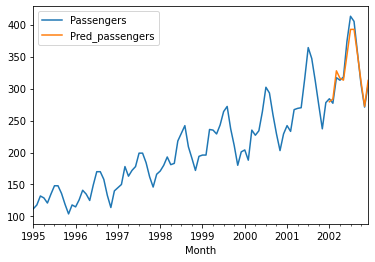

In [49]:
# plotting - Prediction using final model on the train data

FFdata.plot()

As we can see our final model mimics the original data very closely. Also the RMSE overall has reduced but MAPE has slightly increased. the model predictions are satisfactory.

In [50]:
# Calculating Errors
FFdata['Errors'] = pd.Series(FFdata.Passengers - FFdata.Pred_passengers)
FFdata

,Passengers,Pred_passengers,Errors
Month,,,
1995-01-01,112,NaN,NaN
1995-02-01,118,NaN,NaN
1995-03-01,132,NaN,NaN
1995-04-01,129,NaN,NaN
1995-05-01,121,NaN,NaN
...,...,...,...
2002-08-01,405,392.543731,12.456269
2002-09-01,355,352.653113,2.346887
2002-10-01,306,310.444392,-4.444392


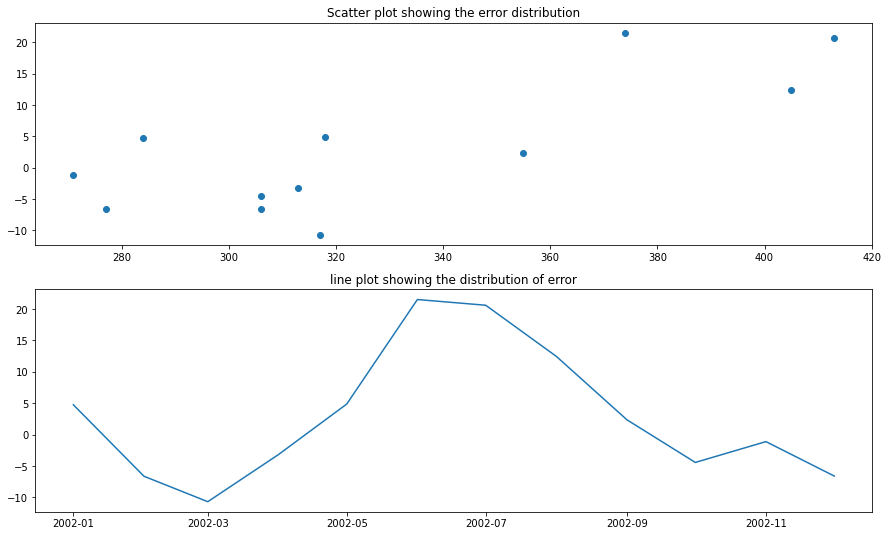

In [51]:
# Plotting the errors
plt.figure(figsize=(15,9))
plt.subplot(211)
plt.scatter(x=FFdata.Passengers,y=FFdata.Errors)
plt.title('Scatter plot showing the error distribution')
plt.subplot(212)
plt.plot(FFdata.Errors)
plt.title('line plot showing the distribution of error')
plt.show()

***As we can clearly see from the above plots that the errors show no patterns. Hence we can finalize this model for future predictions***

# Predictions using our final model

In [52]:
# Creating Data for prediction

PredData = pd.DataFrame({'t':range(97,(97+12)),
                         'month':['2003-01-01','2003-02-01','2003-03-01','2003-04-01','2003-05-01',
                                  '2003-06-01','2003-07-01','2003-08-01','2003-09-01','2003-10-01',
                                  '2003-11-01','2003-12-01'], 
                         'm':['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']})
PredData

,t,month,m
0,97,2003-01-01,Jan
1,98,2003-02-01,Feb
2,99,2003-03-01,Mar
3,100,2003-04-01,Apr
4,101,2003-05-01,May
5,102,2003-06-01,Jun
6,103,2003-07-01,Jul
7,104,2003-08-01,Aug
8,105,2003-09-01,Sep
9,106,2003-10-01,Oct


In [53]:
# Preparing data for prediction using dummies
temp = pd.get_dummies(PredData.m)
PredData = pd.concat([PredData,temp],axis=1)
PredData.set_index('month',inplace=True,append=True)
PredData.drop('m',inplace=True,axis=1)
PredData

,,t,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
,month,,,,,,,,,,,,,
0,2003-01-01,97,0,0,0,0,1,0,0,0,0,0,0,0
1,2003-02-01,98,0,0,0,1,0,0,0,0,0,0,0,0
2,2003-03-01,99,0,0,0,0,0,0,0,1,0,0,0,0
3,2003-04-01,100,1,0,0,0,0,0,0,0,0,0,0,0
4,2003-05-01,101,0,0,0,0,0,0,0,0,1,0,0,0
5,2003-06-01,102,0,0,0,0,0,0,1,0,0,0,0,0
6,2003-07-01,103,0,0,0,0,0,1,0,0,0,0,0,0
7,2003-08-01,104,0,1,0,0,0,0,0,0,0,0,0,0
8,2003-09-01,105,0,0,0,0,0,0,0,0,0,0,0,1


In [54]:
# Predictions using Final Model
predictions = np.exp(F_Mult_tr_Mul_sea.predict(PredData))
predictions

    month     
0   2003-01-01    320.779889
1   2003-02-01    324.173779
2   2003-03-01    374.075905
3   2003-04-01    361.986306
4   2003-05-01    359.632793
5   2003-06-01    407.045777
6   2003-07-01    452.677464
7   2003-08-01    451.720349
8   2003-09-01    404.569872
9   2003-10-01    355.211286
10  2003-11-01    311.768944
11  2003-12-01    357.383375
dtype: float64

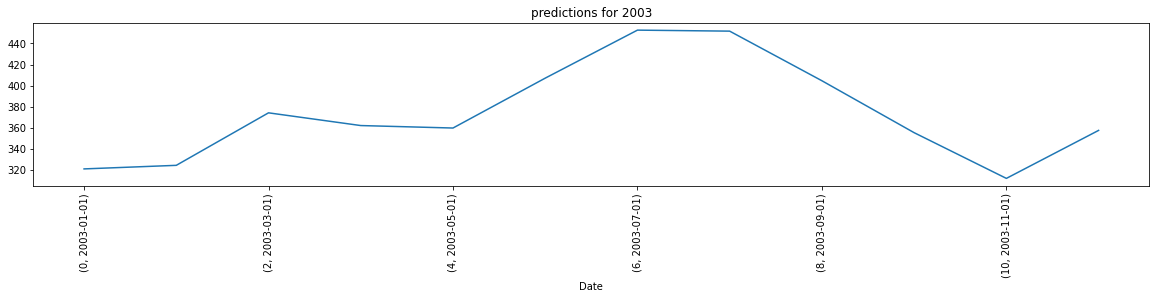

In [58]:
predictions.plot(figsize = (20,3),use_index = True, 
                 title = 'predictions for 2003',rot=90,xlabel='Date')
plt.show()